TRAINING SET:
 X_tr shape = (100, 25), T_tr shape = (100,), YF_tr shape = (100,)
 Treatment ratio = 0.190
TEST SET:
 X_te shape = (100, 25), T_te shape = (100,), YF_te shape = (100,)
 Treatment ratio = 0.190
Epoch 50/200, Train Loss = 220.2332
Epoch 100/200, Train Loss = 22.3657
Epoch 150/200, Train Loss = 5.2685
Epoch 200/200, Train Loss = 4.4264
Training complete.
Test set Factual MSE = 297.7343
Test set PEHE        = 10.7770


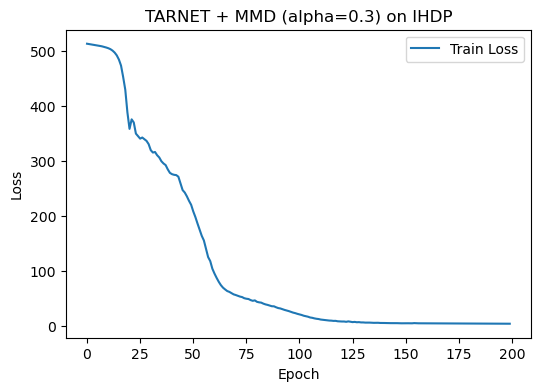

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------
# 1) REPRODUCIBILITY
# ---------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------------------------------------------
# 2) LOAD THE IHDP DATA (first realization)
#    Note: we transpose X so shape = (n_samples, d_features)
# ---------------------------------------------------
train_data = np.load('ihdp_npci_1-100.train.npz')
test_data  = np.load('ihdp_npci_1-100.test.npz')

X_tr = train_data['x'][0]   # shape is (25, 100) => 25 features, 100 samples
T_tr = train_data['t'][0]   # shape (100,)
YF_tr = train_data['yf'][0] # shape (100,) factual
YCF_tr = train_data['ycf'][0]   # shape (100,) counterfactual
mu0_tr = train_data['mu0'][0]   # shape (100,)
mu1_tr = train_data['mu1'][0]   # shape (100,)

X_te = test_data['x'][0]
T_te = test_data['t'][0]
YF_te = test_data['yf'][0]
YCF_te = test_data['ycf'][0]
mu0_te = test_data['mu0'][0]
mu1_te = test_data['mu1'][0]

# Transpose X so that it becomes (n_samples, d)
X_tr = X_tr.T  # now shape is (100, 25)
X_te = X_te.T  # shape e.g. (100, 25)

print("TRAINING SET:")
print(f" X_tr shape = {X_tr.shape}, T_tr shape = {T_tr.shape}, YF_tr shape = {YF_tr.shape}")
print(f" Treatment ratio = {np.mean(T_tr):.3f}")

print("TEST SET:")
print(f" X_te shape = {X_te.shape}, T_te shape = {T_te.shape}, YF_te shape = {YF_te.shape}")
print(f" Treatment ratio = {np.mean(T_te):.3f}")

# ---------------------------------------------------
# 3) MAKE DATALOADER FOR TRAIN
# ---------------------------------------------------
def make_dataloader(X, T, Y, batch_size=64, shuffle=True):
    X_torch = torch.from_numpy(X).float()
    T_torch = torch.from_numpy(T).float()
    Y_torch = torch.from_numpy(Y).float()
    ds = TensorDataset(X_torch, T_torch, Y_torch)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    return dl

train_loader = make_dataloader(X_tr, T_tr, YF_tr, batch_size=64, shuffle=True)

# ---------------------------------------------------
# 4) DEFINE THE TARNET MODEL
#    - 5 shared layers (SharedNet)
#    - 2 heads, each 5 layers (HeadNet)
# ---------------------------------------------------
class SharedNet(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.act(self.fc2(h))
        h = self.act(self.fc3(h))
        h = self.act(self.fc4(h))
        h = self.act(self.fc5(h))
        return h

class HeadNet(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.act(self.fc2(h))
        h = self.act(self.fc3(h))
        h = self.act(self.fc4(h))
        out = self.fc5(h)  # shape (batch,1)
        return out

class TARNET(nn.Module):
    def __init__(self, x_dim=25, shared_dim=64, head_dim=64):
        super().__init__()
        self.shared = SharedNet(x_dim, shared_dim)
        self.head0 = HeadNet(shared_dim, head_dim)
        self.head1 = HeadNet(shared_dim, head_dim)

    def forward(self, x, t):
        """
        x: shape [batch, x_dim]
        t: shape [batch, ] in {0,1}
        returns: predicted outcome y_hat
        """
        phi = self.shared(x)
        y0 = self.head0(phi).squeeze(-1)
        y1 = self.head1(phi).squeeze(-1)
        # Combine
        return (1.0 - t)*y0 + t*y1

    def predict_ite(self, x):
        """
        Return (y1_hat - y0_hat) for each sample
        """
        phi = self.shared(x)
        y0 = self.head0(phi).squeeze(-1)
        y1 = self.head1(phi).squeeze(-1)
        return y1 - y0

# ---------------------------------------------------
# 5) MMD (RBF KERNEL) FOR IPM
# ---------------------------------------------------
def rbf_kernel(x, y, gamma=1.0):
    """
    x: shape (n, d)
    y: shape (m, d)
    return: shape (n, m) with exp(-gamma * ||x-y||^2)
    """
    x2 = torch.sum(x**2, dim=1, keepdim=True)
    y2 = torch.sum(y**2, dim=1, keepdim=True)
    xy = x @ y.t()
    dist = x2 + y2.t() - 2*xy
    k = torch.exp(-gamma * dist)
    return k

def mmd_squared(x_treated, x_control, gamma=1.0):
    """
    MMD^2 = E[k(X_treated,X_treated)] + E[k(X_control,X_control)]
            - 2 E[k(X_treated,X_control)]
    We'll return a single scalar.
    """
    nt = x_treated.shape[0]
    nc = x_control.shape[0]
    if nt<2 or nc<2:
        # not enough data in batch => no penalty
        return torch.tensor(0.0, device=x_treated.device)
    Ktt = rbf_kernel(x_treated, x_treated, gamma)
    Kcc = rbf_kernel(x_control, x_control, gamma)
    Ktc = rbf_kernel(x_treated, x_control, gamma)
    mmd2 = Ktt.mean() + Kcc.mean() - 2*Ktc.mean()
    return mmd2

# ---------------------------------------------------
# 6) TRAINING LOOP
# ---------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = TARNET(x_dim=X_tr.shape[1], shared_dim=64, head_dim=64).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

alpha = 0.3     # weight on IPM penalty
gamma_rbf = 0.1 # RBF scale
num_epochs = 200


train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for bx, bt, byf in train_loader:
        bx, bt, byf = bx.to(device), bt.to(device), byf.to(device)
        optimizer.zero_grad()

        # Factual MSE
        pred = model(bx, bt)
        mse_loss = F.mse_loss(pred, byf)

        # MMD penalty
        phi = model.shared(bx)
        phi_treated = phi[bt>0.5]
        phi_control = phi[bt<0.5]
        mmd2 = mmd_squared(phi_treated, phi_control, gamma=gamma_rbf)
        mmd = torch.sqrt(mmd2 + 1e-8)  # sqrt to get MMD

        loss = mse_loss + alpha*mmd
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * bx.size(0)
        n_samples += bx.size(0)

    epoch_loss = running_loss / n_samples
    train_losses.append(epoch_loss)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss = {epoch_loss:.4f}")

print("Training complete.")

# ---------------------------------------------------
# 7) EVALUATE ON TEST
#    a) Factual MSE
#    b) PEHE = sqrt( E[ ( (mu1 - mu0) - (y1_hat - y0_hat) )^2 ] )
# ---------------------------------------------------
model.eval()
X_te_torch  = torch.from_numpy(X_te).float().to(device)
T_te_torch  = torch.from_numpy(T_te).float().to(device)
YF_te_torch = torch.from_numpy(YF_te).float().to(device)
mu0_te_torch = torch.from_numpy(mu0_te).float().to(device)
mu1_te_torch = torch.from_numpy(mu1_te).float().to(device)

with torch.no_grad():
    # Factual MSE
    preds_factual = model(X_te_torch, T_te_torch)
    test_mse = F.mse_loss(preds_factual, YF_te_torch).item()

    # PEHE
    true_ite = mu1_te_torch - mu0_te_torch
    pred_ite = model.predict_ite(X_te_torch)
    pehe = torch.mean((true_ite - pred_ite)**2).sqrt().item()

print(f"Test set Factual MSE = {test_mse:.4f}")
print(f"Test set PEHE        = {pehe:.4f}")

# ---------------------------------------------------
# 8) PLOT TRAINING LOSS
# ---------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TARNET + MMD (alpha=0.3) on IHDP')
plt.legend()
plt.show()
